In [1]:
from src.similarity_search.similarity_search import TransactionImageSearch
from src.tip_generation.tips_cluster_based import TaxTipGenerator
from src.tip_generation.tips_recommendation_system import EASERecommender
from src.utils import format_tip
import pandas as pd

In [2]:
transactions_df = pd.read_csv("data/transactions_csv.txt")
filings_df = pd.read_csv("data/tax_filings_csv.txt")
users_df = pd.read_csv("data/users_csv.txt")

In [3]:
similarity_search = TransactionImageSearch()


INFO:httpx:HTTP Request: GET http://localhost:6333 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET http://localhost:6333/collections "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: DELETE http://localhost:6333/collections/transaction_image_search "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: PUT http://localhost:6333/collections/transaction_image_search "HTTP/1.1 200 OK"


In [4]:
similarity_search.add_transactions_from_df(transactions_df)
similarity_search.add_images_from_directory("data/receipt")

INFO:httpx:HTTP Request: PUT http://localhost:6333/collections/transaction_image_search/points?wait=true "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: PUT http://localhost:6333/collections/transaction_image_search/points?wait=true "HTTP/1.1 200 OK"


In [5]:
stats = similarity_search.get_statistics()
print(f"Storage: {stats['storage']}")
print(f"Total points: {stats['total_points']}")
print(f"Transactions: {stats['transactions']}")
print(f"Images: {stats['images']}")

INFO:httpx:HTTP Request: GET http://localhost:6333/collections/transaction_image_search "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:6333/collections/transaction_image_search/points/scroll "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:6333/collections/transaction_image_search/points/scroll "HTTP/1.1 200 OK"


Storage: qdrant
Total points: 1050
Transactions: 1045
Images: 5


In [6]:
row = transactions_df.iloc[0]
print(row)
similarity_search.create_transaction_text(row)

transaction_id                     T00800
user_id                             U1013
date                           2022-03-10
amount                              450.0
category                   Work Equipment
subcategory                      Computer
description       Development accessories
vendor                   ElectronicsStore
Name: 0, dtype: object


'$450.00 purchase in Work Equipment for Computer described as Development accessories from ElectronicsStore by user U1013 on 10 March 2022'

In [7]:
results = similarity_search.search_transactions(similarity_search.create_transaction_text(row), top_k=10)
for payload, score in results[1:]:
    print(
        f"Score: {score:.3f} | {payload['transaction_id']}: {payload['text_representation']}"
    )

INFO:httpx:HTTP Request: POST http://localhost:6333/collections/transaction_image_search/points/search "HTTP/1.1 200 OK"


Score: 0.980 | T00859: $420.00 purchase in Work Equipment for Computer described as Laptop accessories from ElectronicsStore by user U1014 on 20 January 2022
Score: 0.976 | T00903: $650.00 purchase in Work Equipment for Computer described as Advanced laptop from ElectronicsStore by user U1014 on 8 February 2023
Score: 0.975 | T00862: $550.00 purchase in Work Equipment for Computer described as Computer upgrade from ElectronicsStore by user U1014 on 5 September 2022
Score: 0.973 | T00543: $580.00 purchase in Work Equipment for Computer described as Laptop upgrade from ElectronicsStore by user U1009 on 5 September 2022
Score: 0.965 | T00540: $350.00 purchase in Work Equipment for Computer described as Tablet for design work from ElectronicsStore by user U1009 on 20 January 2022
Score: 0.951 | T00593: $650.00 purchase in Work Equipment for Computer described as Advanced drawing tablet from ElectronicsStore by user U1009 on 8 February 2023
Score: 0.938 | T00817: $490.00 purchase in Work Eq

In [8]:
results = similarity_search.search_transactions("doctor medical health", top_k=5)
for payload, score in results:
    print(
        f"Score: {score:.3f} | {payload['transaction_id']}: {payload['text_representation']}"
    )

INFO:httpx:HTTP Request: POST http://localhost:6333/collections/transaction_image_search/points/search "HTTP/1.1 200 OK"


Score: 0.894 | T00907: $50.00 purchase in Medical for Doctor Visit described as Routine checkup from Dr. Becker by user U1014 on 20 May 2023
Score: 0.893 | T00613: $90.00 purchase in Medical for Doctor Visit described as Regular checkup from Dr. Müller by user U1010 on 15 May 2022
Score: 0.893 | T00942: $50.00 purchase in Medical for Doctor Visit described as Routine checkup from Dr. Hoffmann by user U1015 on 15 May 2022
Score: 0.892 | T00864: $45.00 purchase in Medical for Doctor Visit described as Routine checkup from Dr. Becker by user U1014 on 20 May 2022
Score: 0.891 | T00652: $95.00 purchase in Medical for Doctor Visit described as Regular checkup from Dr. Müller by user U1010 on 15 May 2023


In [9]:
results = similarity_search.search_by_image("data/receipt/2.png", content_type="both", top_k=10)
for payload, score in results[1:]:
    if payload["type"] == "image":
        print(
            f"Score: {score:.3f} Type: {payload["type"]} filename: {payload["filename"]}"
        )
    else:
        print(
        f"Score: {score:.3f} | {payload['transaction_id']}: {payload['text_representation']}"
        )

INFO:httpx:HTTP Request: POST http://localhost:6333/collections/transaction_image_search/points/search "HTTP/1.1 200 OK"


Score: 0.594 Type: image filename: 4.png
Score: 0.584 Type: image filename: 5.png
Score: 0.567 Type: image filename: 3.png
Score: 0.524 Type: image filename: 1.png
Score: 0.327 | T00266: $90.00 purchase in Medical for Prescription described as Monthly medication from CityApotheke by user U1004 on 10 April 2023
Score: 0.326 | T00265: $90.00 purchase in Medical for Prescription described as Monthly medication from CityApotheke by user U1004 on 10 March 2023
Score: 0.325 | T00264: $90.00 purchase in Medical for Prescription described as Monthly medication from CityApotheke by user U1004 on 10 February 2023
Score: 0.325 | T00230: $85.00 purchase in Medical for Prescription described as Monthly medication from CityApotheke by user U1004 on 10 April 2022
Score: 0.324 | T00229: $85.00 purchase in Medical for Prescription described as Monthly medication from CityApotheke by user U1004 on 10 March 2022


In [10]:
results = similarity_search.search_transactions(
    "expensive purchase", amount_range=(2000, 3000), top_k=3
)
print("Expensive transactions:")
for payload, score in results:
    print(
        f"Score: {score:.3f} | ${payload['amount']}: {payload['text_representation']}"
    )


INFO:httpx:HTTP Request: POST http://localhost:6333/collections/transaction_image_search/points/search "HTTP/1.1 200 OK"


Expensive transactions:
Score: 0.802 | $2050.0: $2050.00 purchase in Self-Employment for Client Payment described as Project completion from Client F by user U1002 on 30 June 2023
Score: 0.800 | $2200.0: $2200.00 purchase in Self-Employment for Client Payment described as Project completion from Client H by user U1002 on 31 August 2023
Score: 0.794 | $2100.0: $2100.00 purchase in Self-Employment for Client Payment described as Project completion from Client C by user U1002 on 31 March 2023


In [11]:
tip_generator = TaxTipGenerator()
tip_generator.load_data(filings_df, transactions_df, users_df)


In [12]:
print(tip_generator.user_features.columns)

Index(['user_id', 'income_level', 'deduction_ratio', 'transaction_frequency',
       'avg_transaction_size', 'spending_diversity', 'occupation_category',
       'age_range', 'family_status', 'region', 'ratio_Business_Meals',
       'ratio_Charitable_Donations', 'ratio_Child_Care', 'ratio_Home_Office',
       'ratio_Insurance', 'ratio_Medical', 'ratio_Professional_Development',
       'ratio_Property_Expenses', 'ratio_Rental', 'ratio_Self-Employment',
       'ratio_Transportation', 'ratio_Travel', 'ratio_Work_Clothing',
       'ratio_Work_Equipment'],
      dtype='object')


In [13]:
tip_generator.cluster_data()
print(tip_generator.cluster_summary())

INFO:src.tip_generation.tips_cluster_based:Cluster 0: Users=11, AvgIncome=€68,136, AvgDedRatio=3.9%, TopOcc=IT Professional, AgeRange=30-40, Members=[U1001, U1003, U1006, U1007, U1008, U1010, U1011, U1012, U1013, U1015, U1016]
INFO:src.tip_generation.tips_cluster_based:Cluster 1: Users=5, AvgIncome=€77,900, AvgDedRatio=4.2%, TopOcc=Healthcare, AgeRange=50-60, Members=[U1004, U1017, U1018, U1019, U1020]
INFO:src.tip_generation.tips_cluster_based:Cluster 2: Users=3, AvgIncome=€76,000, AvgDedRatio=4.4%, TopOcc=Self-Employed, AgeRange=30-40, Members=[U1002, U1009, U1014]
INFO:src.tip_generation.tips_cluster_based:Cluster 3: Users=1, AvgIncome=€89,000, AvgDedRatio=3.5%, TopOcc=Finance, AgeRange=40-50, Members=[U1005]


None


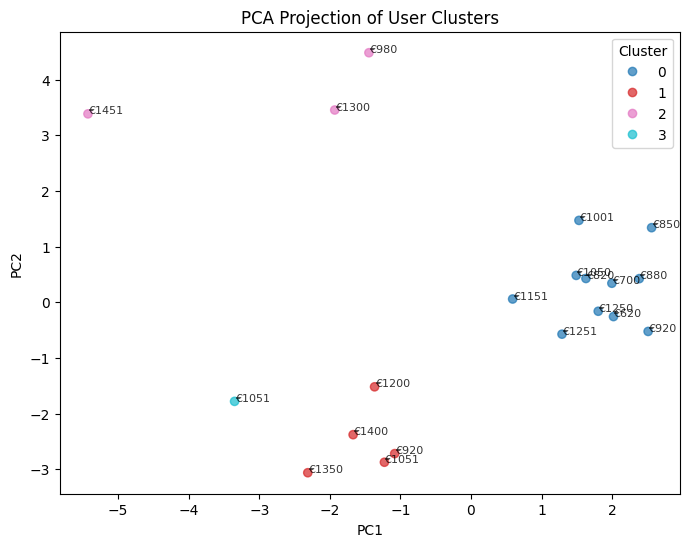

In [14]:
tip_generator.plot_cluster_pca()

In [24]:
user_id = "U1002"
print(format_tip(tip_generator.generate_personalized_tips(user_id=user_id, top_k=3)))

Your refund amount: €1,450.75
Peer cluster average refund amount: €1,100.62

1. Child Care Expense Gap
    Similar users spend 9.6% of income on child care (vs your 0.0%). You might be missing deductible purchases.
    Action: Review child care expenses
2. Work Equipment Expense Gap
    Similar users spend 5.4% of income on work equipment (vs your 0.0%). You might be missing deductible purchases.
    Action: Review work equipment expenses
3. Transportation Expense Gap
    Similar users spend 1.8% of income on transportation (vs your 0.0%). You might be missing deductible purchases.
    Action: Review transportation expenses


In [25]:
rec = EASERecommender()

In [26]:
rec.load_data(transactions_df, users_df, filings_df)
rec.train()


INFO:src.tip_generation.tips_recommendation_system:EASE training finished.


In [36]:
user_id = "U1002"
print(f"Top recommendations for {user_id}: {rec.recommend(user_id)}")


Top recommendations for U1002: ['Work Equipment', 'Transportation', 'Child Care']


In [35]:
k=3
metrics = rec.evaluate(k=k)
print(f"EASE evaluation: HR@{k}={metrics[f'HR@{k}']:.4f}, MAP@{k}={metrics[f'MAP@{k}']:.4f}")

EASE evaluation: HR@3=0.7500, MAP@3=0.5729
